# 作って理解するTransformer/Attention
[作って理解する Transformer/Attention](https://qiita.com/halhorn/items/c91497522be27bde17ce)を参考にTransformerを勉強  
Attentionベースの自然言語処理モデルはこれからのデファクトスタンダード！

## 歴史

### RNNからAttentionへ
NLP×DLといえばSeq2SeqなどのLSTM，GRUといったRNNだった  
ところが，Attention is All You NeedのTransformerが機械翻訳のスコアを大きく引き上げる  
TransformerのEncoder部分はBERTなどで高い性能を持つモデルへと応用されていった  

### Attentionの利点
- 性能が良い: SOTAの多くがAttentionベース
- 学習が早い: 前の時刻を計算してから次を計算するRNNに比べて
- 構造がシンプル: 全結合と行列積くらい

### Transformerを知る
[論文解説 Attention Is All You Need (Transformer)](http://deeplearning.hatenablog.com/entry/transformer)が分かりやすいのでざっと目を通す  
本家論文は[arXiv](https://arxiv.org/abs/1706.03762)で

## Transformerを作る
「作る」は「理解する」の近道！  
Attentionをベースとする，Transformerの実装に取り組む
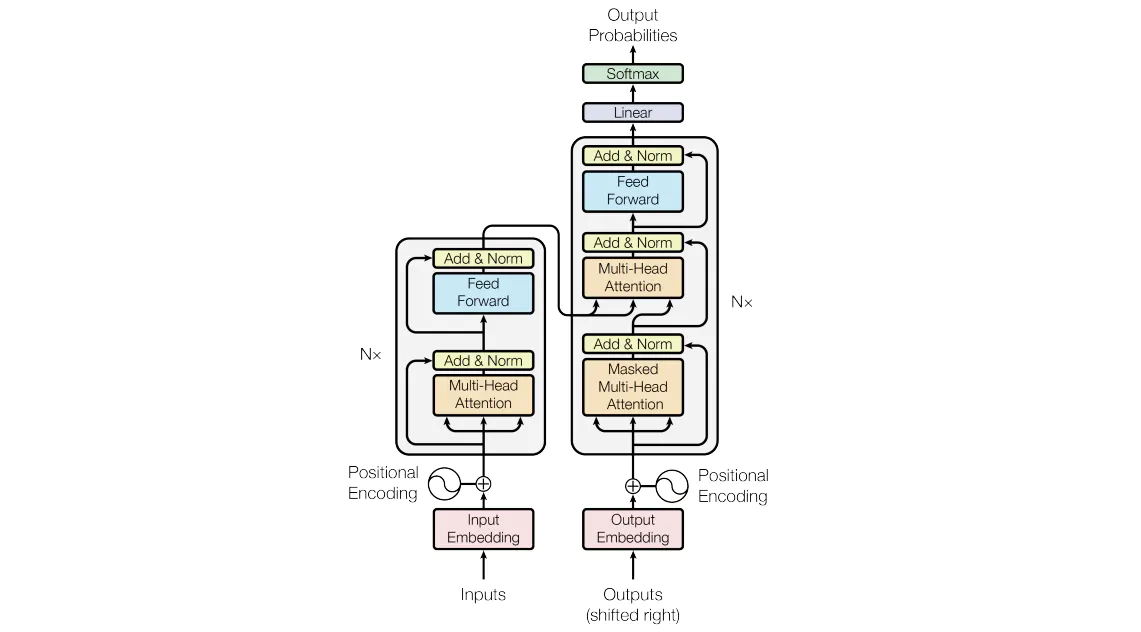

### 基本的なAttention
attentionの基本はqueryによってmemory(key, value)から必要な情報を選択的に引っ張ってくること    
queryはkeyによって取得するmemoryを決定し，対応するvalueを取得する  
これがRNNによるEncoder-Decoderモデルと同様の効果をもたらす  
  
まずは基本的なAttentionネットワークを作ってみる  
白丸がテンソル，灰四角がレイヤ
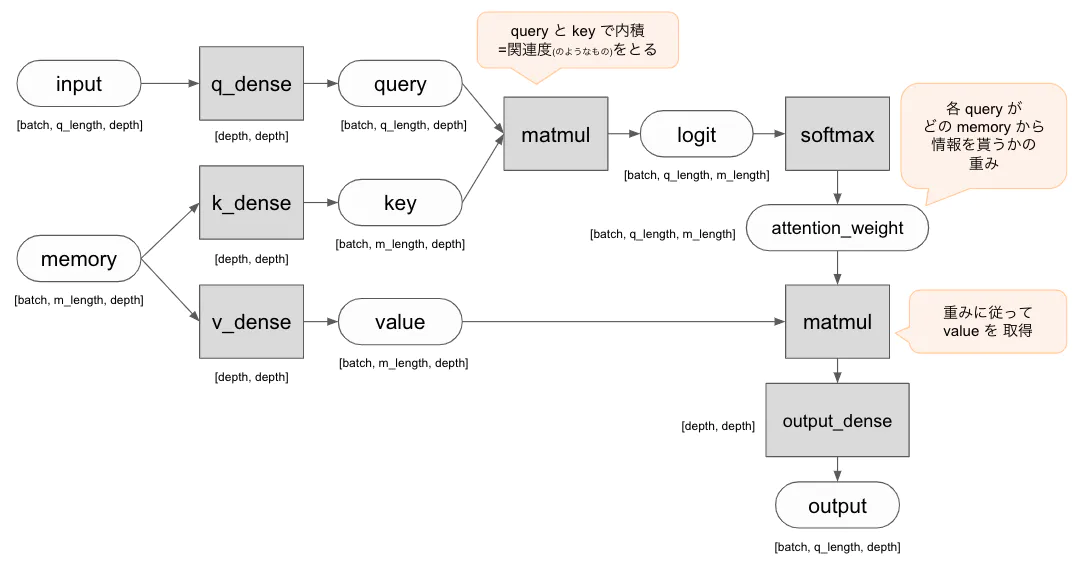

以降，行列のタテヨコは2次元配列をprintしたときの方向とする

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense

class SimpleAttention(tf.keras.models.Model): # ネットワークの基礎モジュール
    ''' Simple Single Head Attention '''
    
    def __init__(self, depth: int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.depth = depth # 分散表現ベクトルの次元数(ヨコ)
        
        self.q_dense_layer = Dense(depth, use_bias=False, name='q_dense_layer')
        self.k_dense_layer = Dense(depth, use_bias=False, name='k_dense_layer')
        self.v_dense_layer = Dense(depth, use_bias=False, name='v_dense_layer')
        self.output_dense_layer = Dense(depth, use_bias=False, name='output_dense_layer')
    
    def call(self, inputs: tf.Tensor, memory: tf.Tensor) -> tf.Tensor: # forward
        q = self.q_dense_layer(inputs) # [batch, q_length, depth]
        k = self.k_dense_layer(memory) # [batch, m_length, depth]
        v = self.v_dense_layer(memory) # [batch, m_length, depth]
        
        # qとk(転置)の内積を取り，queryとkeyの関連度のようなものを計算
        logit = tf.matmul(q, k, transpose_b=True) # [batch, q_length, m_length]
        
        # softmaxを取り正規化
        attention_weight = tf.nn.softmax(logit, name='attention_weight')
        
        # 重みに従ってvalueから情報を引いてくる
        attention_output = tf.matmul(attention_weight, v) # [batch, q_length, depth]
        
        return self.output_dense_layer(attention_output)

attention_weightはqueryがmemoryのどこからどれくらい情報を引いてくるかをkeyとの関連度から取得した値で，queryとkeyの行列積(matmul)で計算する  
Softmaxでquery(ヨコ，単語)ごとのweightの合計を1にするよう規格化している  
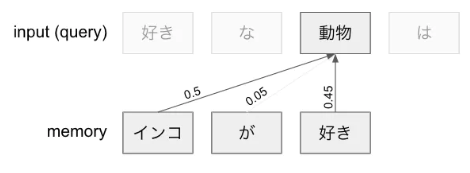

そしてattention_weightとvalueの行列積を取る．  
上図の例だと，`attn(動物) = value(インコ) * 0.5 + value(が) * 0.05 + value(好き) * 0.45`  
ここで，`attn(動物)`は「動物」のところのAttentionの出力ベクトル(ヨコ)  
これで得られたベクトルをさらにDenseで変換したものがこのレイヤーの出力

別の書き方をするとこんな感じ  
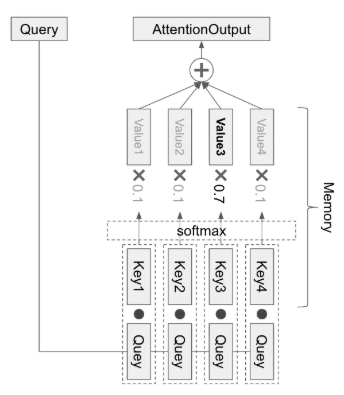

### Attentionの使い方
このAttentionには大きく2つの使い方がある  

#### Self-Attention
input, memory(key, value)のすべてに同じTensorを使うAttention  
言語の文保構造，指示語(itとか)対応などの照応関係を獲得するのに使えそう  
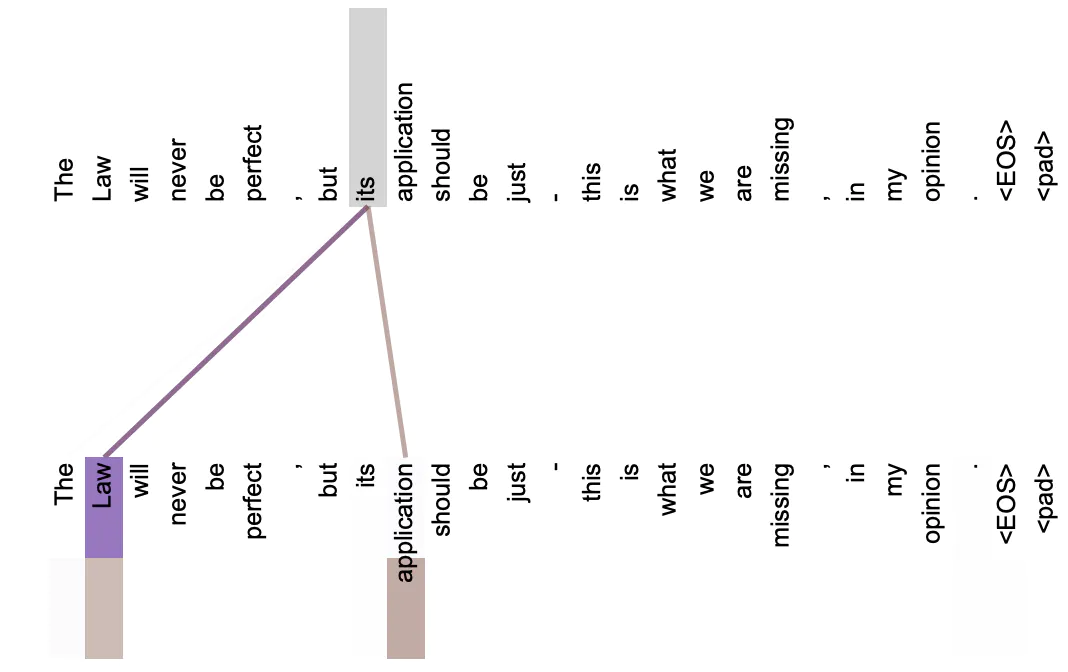
上段のqueryのitsに対してLowが対応していることが分かる  
Self-Attentionは汎用的に使える強力な仕組みである

#### SourceTarget-Attention
inputとmemory(key,value)が別々のTensorを使うAttention  
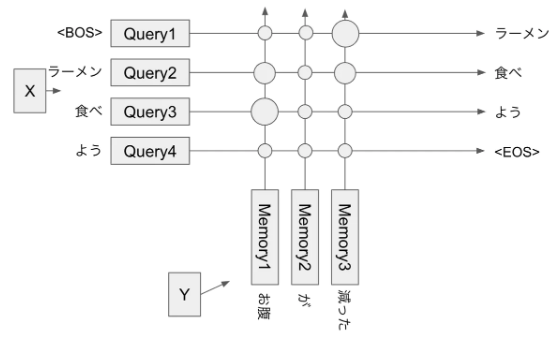

ある時刻tのトークンを受け取って過去の発話を基にt+1のトークンを予測  
ラーメン -> 「お腹が減った」のmemoryを受け取る -> 食べ -> ...  
のようにして文章全体を作り出す

もっとダイレクトに，queryを質問，memoryは応答の候補とし，queryに一番関係ありそうな応答から情報を引いてくるものもある  
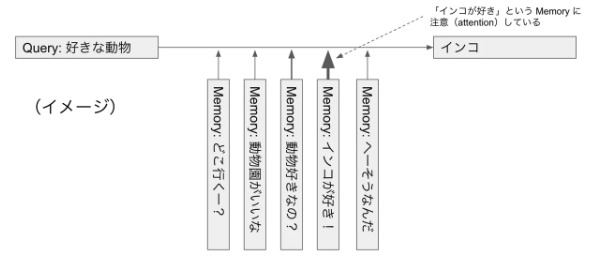

ここから先では，基本のAttentionの学習をうまくいくようにする工夫を紹介

### Scaled Dot-production
Softmax関数はlogitの値が大きいと分母が大きくなりすぎ，勾配が0に近くなってしまう  
logitは行列積なので，分散表現の次元数depthが大きいほどlogitも大きくなってしまう  
そこで，queryの大きさをdepthに従って小さくする  
$$ attention\_weight = softmax\Big( \frac{qk^\top}{\sqrt{depth}} \Big) $$
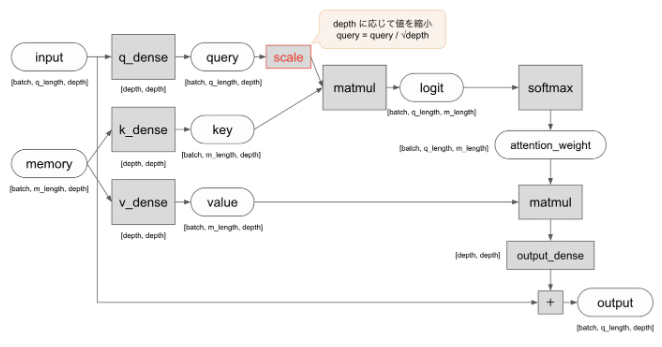

``` python
q *= depth ** -0.5
logit = tf.matmul(q, k, transpose_b=True)
attention_weight = tf.nn.softmax(logit, name='attention_weight')
```

## Mask
次のような場合，特定のkeyに対してattention_weightを0にしたい
- PADを無視したい
- DecoderのSelf-Attentionで未来の情報を参照できないようにしたい

attention_weightはSoftmaxの出力なので，その入力であるlogitのmaskしたい要素を-∞にする  
$$ softmax_i = \frac{e^{x_i}}{\sum_j e^{x_j}} $$
$$ e^{-\infty} = 0 $$

``` python
logit = tf.matmul(q, k, transposeb=True)
logit += tf.to_float(attention_mask) * inputs.dtype.min
attention_weight = tf.nn.softmax(logit, name='attention_weight')
```
ここでattention_maskは[batch, q_length, m_length]で，0にしたい部分がTrueであとFalse

#### PADを無視したい
一般的に入力する文章の長さはバラバラである  
長さをそろえるため，最大の単語数を設定し，それに足りていない分にPADを入れる  
そのPADには着目しないでほしいため，attention_weightを0にする  
例えば，memory = `おはよう / <PAD> / <PAD>`に対するmaskは次のようになる  
``` python
[[False, True, True],
 [False, True, True],
 [False, True, True],
 [False, True, True]]
```
これらのmaskの作り方は最後の全体コードに載せる

#### DecoderのSelf-Attentionで未来の情報を参照できないようにしたい
Decoderはある時刻tの入力からt+1を予測することを繰り返す(自己回帰)  
このとき，予測対象の未来の情報が得られてしまうと困るので，隠す  
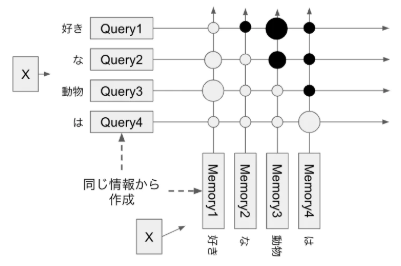  
この場合，maskは次のようになる
``` python
[[False, True,  True,  True],
 [False, False, True,  True],
 [False, False, False, True],
 [False, False, False, False]]
```

### Multi-head Attention
1つの大きなAttentjonを扱うより小さな複数のHeadに分けてAttentionする方が経験的に性能が上がるらしい  
query, key, valueをそれぞれhead_num個にsplitしてからそれぞれ計算，最後にconcatする  
  
以上，これまでの
- Simple Attention
- Scaled Dot-production
- Mask
- Multi-head Attention

を組み合わせ，以降の基礎となる次のようなMultiheadAttentionモジュールを作成する  
さらに，随所にDropoutを追加することで汎化性能を上げられる(過学習を防ぐ?)のでそれもやる

In [ ]:
class MultiheadAttention(tf.keras.models.Model):
    def __init__(self, hidden_dim: int, head_num: int, dropout_rate: float, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.head_num = head_num
        self.dropout_rate = dropout_rate
        
        self.q_dense_layer = Dense(hidden_dim, use_bias=False, name="q_dense_layer")
        self.k_dense_layer = Dense(hidden_dim, use_bias=False, name="k_dense_layer")
        self.v_dense_layer = Dense(hidden_dim, use_bias=False, name="v_dense_layer")
        self.output_dense_layer = Dense(hidden_dim, use_bias=False, name="output_dense_layer")
        
    def call(self, input: tf.Tensor, memory: tf.Tensor, attention_mask: tf.Tensor, training: bool):
        